# Start

In [1]:
import pandas as pd
import numpy as np
import pickle 

import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time

In [1]:
# maximum text
# sb.set()
# pd.set_option('display.max_colwidth', None)

# Load dataset

In [2]:
def count_words(text):
    counter = 0
    for i in text:
        counter += len(i.split())
    return counter

def count_token(text):
    s = set()
    for i in text:
        tokenize = i.split()
        for j in tokenize:
            s.add(j)    
    return len(s)


def load_dataset(ds, opt=2):
    if ds == 1:
        dataset_name = "GabHateCorpus"
    elif ds == 2:
        dataset_name = "Implicit_hate_corpus"
    elif ds == 3:
        dataset_name = "SE2019"
    else:
        dataset_name = "Balanced"

    filepath = "Dataset/"+dataset_name
    if opt==1:
        df = pd.read_csv(filepath+"/data_processed.csv")
    elif opt==2:
        df = pd.read_csv(filepath+"/data_processed2.csv")
    else:
        df = pd.read_csv(filepath+"/data_needed.csv")
    print(df['class'].value_counts(normalize=True))
    return df, dataset_name

In [15]:
df, ds_name = load_dataset(4,3)
count_token(df['text'])

class
Hate        0.5
Non-Hate    0.5
Name: proportion, dtype: float64


82692

## data analyze

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34002 entries, 0 to 34001
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   34002 non-null  object
 1   text    34002 non-null  object
 2   hate    34002 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 797.0+ KB


In [5]:
df.head(5)

,class,text,hate
0,Non-Hate,feminsts sjws gets owned cringe compilation co...,0
1,Hate,hey fellow whites sit let lecture terrible,1
2,Non-Hate,evolved potential currency asset soon become r...,0
3,Hate,mil milstalin milhitler milmao milpolpot miln ...,1
4,Hate,liberalism mental disorder much dangerous thou...,1


In [5]:
df[df['text'].isnull()]

,class,text,hate


### word counter

In [41]:
filepath = "Dataset/SE2019/"
df_need = pd.read_csv(filepath+"data_needed.csv")
df_processed = pd.read_csv(filepath+"data_processed.csv")
print(len(df_need), len(df_processed))

13000 12974


In [42]:
text_need = np.array(df_need["text"])
text_processed = np.array(df_processed["text"])

In [43]:
print("word")
print("need: ", count_words(text_need))
print("pro: ", count_words(text_processed))

print("token")
print("need: ", count_token(text_need))
print("pro: ", count_token(text_processed))

word
need:  281058
pro:  156009
token
need:  53046
pro:  22855


# Split dataset

In [3]:
def split_data(df):
    test_size = 0.20
    x = np.array(df["text"])
    y = np.array(df["class"])

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = test_size, random_state=42) #random state ensure same sample
    print("Train Set :", x_train.shape, y_train.shape) 
    print("Test Set  :", x_test.shape, y_test.shape) 
    print("Total ", len(df))
    # y in digit form
    y_train_binary = np.array(list(map(lambda x:1 if x=="Hate" else 0, y_train)))
    y_test_binary = np.array(list(map(lambda x:1 if x=="Hate" else 0, y_test)))
    return x_train, y_train, y_train_binary, x_test, y_test, y_test_binary

# Feature engineering - Word embeding

- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
- CountVectorizer, Tfidftransformer & Tfidfvectorizer are Frequency based Word Embedding technique
- Tfidftransformer acts on sparse matrix and Tfidfvectorizer acts on raw text data
- Tfidfvectorizer = countVectorizater + Tfidftransformer

- https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
- vectorizer = word embedding process of converting text data to numerical vector

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Word2Vec

- https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#:~:text=Word2Vec%20is%20a%20popular%20algorithm,a%20large%20corpus%20of%20text
- Word2vec is not a single algorithm but a combination of two techniques – CBOW(Continuous bag of words) and Skip-gram model.

In [9]:
from gensim.models import Word2Vec

In [10]:
class w2vVectorizer():
    def __init__(self) -> None:
        self.w2v_model = None
    
    def w2v_vectorizer(self,sentence):
        # vectorize the text data
        words = sentence.split()
        words_vec = [self.w2v_model.wv[word] for word in words if word in self.w2v_model.wv]
        if len(words_vec) == 0:
            return np.zeros(100)
        words_vec = np.array(words_vec)
        return words_vec.mean(axis=0)
    
    def fit(self, x, y=None):
        # train the model when fit the pipeline
        sentences = [sentence.split() for sentence in x]
        self.w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
        return self
    
    def transform(self, x, y=None):
        # when use fit or transform on the pipeline 
        return np.array([self.w2v_vectorizer(sentence) for sentence in x])

# Machine learning

In [10]:
# save model
def save_model(model, model_name):
    filename = f"models/{model_name}.pickle"
    pickle.dump(model, open(filename,"wb"))

## Decision Tree

In [14]:
#convert given text to a vector base
from sklearn.tree import DecisionTreeClassifier

In [424]:
model = Pipeline([('vect', CountVectorizer()),
               ('clf', DecisionTreeClassifier()),
              ])
model_name = "dtc"
model.fit(x_train, y_train)
save_model(model,model_name)

In [232]:
model = Pipeline([('vect', TfidfVectorizer()),
               ('clf', DecisionTreeClassifier()),
              ])
model_name = "dtc-tfid"
model.fit(x_train, y_train)
save_model(model,model_name)

In [233]:
model = Pipeline([('vect', w2vVectorizer()),
               ('clf', DecisionTreeClassifier()),
              ])
model_name = "dtc-w2v"
model.fit(x_train, y_train)
save_model(model,model_name)

## Support Vector Machine

- supervisied learning algorithm
- Unlike neural networks, SVMs can work with very small datasets and are not prone to overfitting.

In [39]:
from sklearn.linear_model import SGDClassifier

In [234]:
model = Pipeline([('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
model_name = "svm"
model.fit(x_train, y_train)
save_model(model, model_name)

In [235]:
model = Pipeline([('vect', TfidfVectorizer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])
model_name = "svm-tfid"
model.fit(x_train, y_train)
save_model(model, model_name)

In [236]:
model = Pipeline([('vect', w2vVectorizer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])
model_name = "svm-w2v"
model.fit(x_train, y_train)
save_model(model, model_name)

## Logistic Regression 

In [46]:
from sklearn.linear_model import LogisticRegression

In [237]:
model = Pipeline([('vect', CountVectorizer()),
        ('clf', LogisticRegression(n_jobs=1, C=1e5,max_iter=6300)),
        ])
model_name = "lr"
model.fit(x_train, y_train)
save_model(model, model_name)

In [238]:
model = Pipeline([('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(n_jobs=1, C=1e5,max_iter=6300)),
        ])
model_name = "lr-tfid"
model.fit(x_train, y_train)
save_model(model, model_name)

In [239]:
model = Pipeline([('vect', w2vVectorizer()),
        ('clf', LogisticRegression(n_jobs=1, C=1e5,max_iter=6300)),
        ])
model_name = "lr-w2v"
model.fit(x_train, y_train)
save_model(model, model_name)

## Predict

In [ ]:
# Predict data
print("Test Data Accuracy  :\t", model.score(x_test, y_test))
y_test_pred = model.predict(x_test)

# Deep Neural network

tensorflow gpu 
- https://www.tensorflow.org/install/pip#windows-native
- https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/ 

- https://www.youtube.com/watch?v=oWo9SNcyxlI
- good read for = https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-022-01665-y


## pre

In [4]:
from keras.models import Sequential
from keras.utils.data_utils import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding
from keras.layers import Conv1D, LSTM, SpatialDropout1D, Bidirectional, GRU, SimpleRNN, TextVectorization

from keras.metrics import BinaryAccuracy,Precision,Recall
import keras
from keras.models import load_model
import tensorflow as tf

from gensim.models import FastText, Word2Vec, KeyedVectors

In [5]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        super(TimingCallback, self).__init__()

    def on_train_begin(self, epoch, logs={}):
        self.starttime = time.time()
    def on_train_end(self, epoch, logs={}):
        self.stoptime = time.time()
        print(f"training time {self.stoptime - self.starttime}")
        
METRICS = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall")
]

def get_classification_report(i, cr):
    return [i, cr['accuracy'], cr['macro avg']['precision'], 
            cr['macro avg']['recall'], cr['macro avg']['f1-score'],
            cr['Hate']['f1-score'],cr['Non-Hate']['f1-score'], 
            cr['Hate']['support'],cr['Non-Hate']['support']]

def get_result_table():
    c = ['Model', 'Accuracy', 'precision', 'recall', 'f1-score', 'hate f1', "non-hate f1", 'hate support', 'non-hate support']
    result_table = pd.DataFrame(columns=c)
    return result_table

def get_result_single(y_test, y_test_pred, model_name, result_table):
    # c = ['Model', 'Accuracy', 'precision', 'recall', 'f1-score', 'hate f1', "non-hate f1", 'hate support', 'non-hate support']
    # result_table = pd.DataFrame(columns=c)

    cr = classification_report(y_test, y_test_pred, labels=["Hate","Non-Hate"], output_dict=True)
    result_table.loc[len(result_table)] = get_classification_report(model_name, cr)
    # return result_table

def get_result_multiple(x_test, y_test, model_to_load):
    c = ['Model', 'Accuracy', 'precision', 'recall', 'f1-score', 'hate f1', "non-hate f1", 'hate support', 'non-hate support']
    result_table = pd.DataFrame(columns=c)
    for i in model_to_load:
        filename = f"models/{i}"
        print(filename)
        old_model = load_model(filename)

        y_test_pred = old_model.predict(x_test, verbose=0)
        y_test_pred = np.where(y_test_pred > 0.5, "Hate", "Non-Hate") 
        y_test_pred = y_test_pred.flatten()

        cr = classification_report(y_test, y_test_pred, labels=["Hate","Non-Hate"], output_dict=True)
        result_table.loc[len(result_table)] = get_classification_report(i, cr)
    return result_table.style.highlight_max(color = 'red', axis = 0)

def nn_predict(model,x_test, y_test_binary):
    score = model.evaluate(x_test, y_test_binary, verbose=0)
    print("Score: ", score[0])
    print("Accuracy: ", score[1])

    y_test_pred_percent = model.predict(x_test, verbose=0)
    y_test_pred = np.where(y_test_pred_percent > 0.5, "Hate", "Non-Hate") 
    y_test_pred = y_test_pred.flatten()

    return y_test_pred

def save_model_nn(model, model_name, embedding_name, dataset_name):
    filename = f"models/{dataset_name}_{embedding_name}_{model_name}"
    model.save(filename)
    return filename

def load_model_nn(model_name):
    filename = f"models/{model_name}"
    print(filename)
    return load_model(filename) 

def compile_fit_save(x_train, y_train_binary, x_test,y_test_binary, model, model_name, embedding_name, dataset_name, save, epoch=5, batch_size=32, lr=0.01):    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=METRICS)
    
    history = model.fit(x_train, y_train_binary, epochs=epoch,
                        validation_data=(x_test,y_test_binary),
                        batch_size = batch_size,
                        callbacks=[TimingCallback()])

    if save: 
        save_model_nn(model, model_name, embedding_name, dataset_name)        
    print(f"acc {history.history['val_accuracy'][0]}")
    return model, history

In [8]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print(tf.config.list_physical_devices())

Tensorflow version: 2.10.1
Keras Version: 2.10.0
GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## embedding

### Glove embedding

In [6]:
def glove_em(x_train):
    embedding_name = "glove"
    text_length = 50 #pad/truncate text to this long, such that each text after token will be this long

    custom_encoder = TextVectorization(
        standardize = None,
        output_sequence_length=text_length, 
    )
    custom_encoder.adapt(x_train)
    vocab = custom_encoder.get_vocabulary()
    print(f"total vocab {len(vocab)}")
    vocab_dict = dict(zip(vocab, range(len(vocab))))

    # load glove to dictionay
    embeddings_dic = dict()
    glove_file = open("Dataset/trained/glove.42B.300d.txt", encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dic[word] = vector_dimensions
    glove_file.close()
    print("Total words ", len(embeddings_dic))

    # create vocab length is the size of token in dictionary
    # Size of the vocabulary
    vocab_length = len(vocab) + 1
    embedding_dim = 300 #each glove word is 100 long

    hits = 0
    miss = 0
    missWord = []

    # create embedding matrix having 100 col
    # for all vocab word we give it a vector value from glove
    # for those not found in glove will be empty 0
    # size of embedding_matriz = size of word_tokenizer.word_index.items()
    # embedding_matrix is the weight 
    embedding_matrix = np.zeros((vocab_length, embedding_dim))
    for word, index in vocab_dict.items():
        embedding_vector = embeddings_dic.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            hits += 1
        else:
            miss +=1
            missWord.append(word)
    print("Converted %d words (%d misses)" % (hits, miss))

    custom_embedding = Embedding(vocab_length, embedding_dim, 
                embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                trainable = False,
                input_length=text_length,
                mask_zero=True)
    
    return custom_encoder, custom_embedding, embedding_name, missWord

### FastText + word2vec

- https://medium.com/@93Kryptonian/word-embedding-using-fasttext-62beb0209db9
- It treats each word as composed of n-grams. In word2vec each word is represented as a bag of words but in FastText each word is represented as a bag of character n-gram.


In [7]:
def get_fasttext_model():
    model_name="fasttext_trained"
    return KeyedVectors.load_word2vec_format("./Dataset/trained/wiki-news-300d-1M-subword.vec", binary=False), model_name

def get_word2vec_model():
    model_name = "word2vec_trained"
    return KeyedVectors.load_word2vec_format("./Dataset/trained/GoogleNews-vectors-negative300.bin", binary=True), model_name

def pre_trained_em(x_train, model_em, embedding_name):
    text_length = 50 #pad/truncate text to this long, such that each text after token will be this long

    custom_encoder = TextVectorization(
        standardize = None,
        output_sequence_length=text_length, 
    )
    custom_encoder.adapt(x_train)
    vocab = custom_encoder.get_vocabulary()
    print(f"total vocab {len(vocab)}")
    vocab_dict = dict(zip(vocab, range(len(vocab))))

    vocab_length = len(vocab) + 1
    embedding_dim = 300 

    hits = 0
    miss = 0
    missWord = []

    embedding_matrix = np.zeros((vocab_length, embedding_dim))
    keyVector_key = model_em.index_to_key
    print(f"total vector {len(keyVector_key)}")
    for word, index in vocab_dict.items():
        if word in keyVector_key:
            embedding_vector = np.array(model_em[word])
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
                hits += 1
        else:
            miss +=1
            missWord.append(word)
            
    print("Converted %d words (%d misses)" % (hits, miss))

    custom_embedding = Embedding(vocab_length, embedding_dim, 
                embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                trainable = False,
                input_length=text_length,
                mask_zero=True)
    
    return custom_encoder, custom_embedding, embedding_name, missWord

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
m2 = dict()
glove_file = open("Dataset/trained/glove.42B.300d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    m2[word] = vector_dimensions
glove_file.close()

In [19]:
m = get_word2vec_model()[0]

In [60]:
men = m['hate']
women = m['detest']
cosine_similarity(men.reshape(1,-1), women.reshape(1,-1))

array([[0.61790377]], dtype=float32)

array([[0.5600246]], dtype=float32)

In [22]:
m.similarity("men", "women")

0.7674937

In [14]:
def fasttext_em(x_train):
    embedding_name = "fasttext"
    text_length = 50 #pad/truncate text to this long, such that each text after token will be this long
    vector_size=100

    sentences = [sentence.split() for sentence in x_train]
    ft_model = FastText(sentences, vector_size=vector_size, window=5, min_count=2, workers=4, seed=42, sg=1, epochs=10) # skip gram or cbow=0
    ft = ft_model.wv
    ft_vocab = ft.index_to_key

    custom_encoder = TextVectorization(
        standardize = None,
        output_sequence_length=text_length, 
        vocabulary = ft_vocab
    )

    vocab = custom_encoder.get_vocabulary()
    print(f"total vocab {len(vocab)}")
    vocab_dict = dict(zip(vocab, range(len(vocab))))

    vocab_length = len(vocab) + 1
    embedding_dim = vector_size

    hits = 0
    miss = 0

    embedding_matrix = np.zeros((vocab_length, embedding_dim))
    for word, index in vocab_dict.items():
        embedding_vector = ft[word]
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            hits += 1
        else:
            miss +=1
    print("Converted %d words (%d misses)" % (hits, miss))

    custom_embedding = Embedding(vocab_length, embedding_dim, 
                embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                trainable = False,
                input_length=text_length,
                mask_zero=True)
    return custom_encoder, custom_embedding, embedding_name

In [9]:
def word2vec_em(x_train):
    embedding_name = "word2vec"
    text_length = 50 #pad/truncate text to this long, such that each text after token will be this long
    vector_size=100

    sentences = [sentence.split() for sentence in x_train]
    w_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42, sg=1, epochs=10)
    w = w_model.wv
    w_vocab = w.index_to_key

    custom_encoder = TextVectorization(
        standardize = None,
        output_sequence_length=text_length, 
        vocabulary = w_vocab
    )

    vocab = custom_encoder.get_vocabulary()
    print(f"total vocab {len(vocab)}")
    vocab_dict = dict(zip(vocab, range(len(vocab))))

    vocab_length = len(vocab) + 1
    embedding_dim = vector_size

    hits = 0
    miss = 0

    embedding_matrix = np.zeros((vocab_length, embedding_dim))
    for word, index in vocab_dict.items():
        if word in w.key_to_index:
            embedding_vector = w[word]
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
                hits += 1
            else:
                print(word)
                miss +=1
        else:
            print(word)
            miss +=1
    print("Converted %d words (%d misses)" % (hits, miss))

    custom_embedding = Embedding(vocab_length, embedding_dim, 
                embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                trainable = False,
                input_length=text_length,
                mask_zero=True)
    return custom_encoder, custom_embedding, embedding_name

### test without pre-trained

In [38]:
def noTrained_em(x_train):
    embedding_name = "no_train"
    text_length = 50 #pad/truncate text to this long, such that each text after token will be this long
    vector_size= 300

    custom_encoder = TextVectorization(
        standardize = None,
        output_sequence_length=text_length, 
    )
    custom_encoder.adapt(x_train)
    vocab = custom_encoder.get_vocabulary()
    print(f"total vocab {len(vocab)}")
    vocab_dict = dict(zip(vocab, range(len(vocab))))

    vocab_length = len(vocab) + 1
    embedding_dim = vector_size

    custom_embedding = Embedding(vocab_length, embedding_dim,
                input_length=text_length,
                mask_zero=True)
    return custom_encoder, custom_embedding, embedding_name

## Deep learning Models

### helper

In [53]:
from keras.layers import BatchNormalization

In [61]:
def add_connected_layer(model):
    # model.add(Dropout(0.2))
    # model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

### models

In [16]:
def cnn(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "cnn"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    add_connected_layer(model)
    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)

def rnn(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "rnn"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    model.add(SimpleRNN(128))
    add_connected_layer(model)
    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)

def lstm(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "lstm"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    # model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128))
    add_connected_layer(model)
    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)

def gru(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "gru"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    # model.add(SpatialDropout1D(0.2))
    model.add(GRU(128))
    add_connected_layer(model)
    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)



### RNN - LSTM

- GOOD = https://medium.com/mlearning-ai/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad

In [33]:
def lstm(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "lstm"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    # model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128))
    add_connected_layer(model)

    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)

### RNN - BILSTM

In [13]:
def bilstm(custom_encoder, custom_embedding, embedding_name):
    print("bilstm")
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=METRICS)

    history = model.fit(x_train, y_train_binary, epochs=10,
                        validation_data=(x_test,y_test_binary))

    save_model_nn(model, "bilstm", embedding_name, dataset_name)
    print(f"acc {history.history['val_accuracy'][0]}")
    return history

### RNN - GRU

In [34]:
def gru(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "gru"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    # model.add(SpatialDropout1D(0.2))
    model.add(GRU(128))
    add_connected_layer(model)

    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)


### RNN 

- https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [35]:
def rnn(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name, save = True, epoch = 10, batch_size=32, lr=0.01):
    model_name = "rnn"
    print(model_name)
    model = Sequential()
    model.add(custom_encoder)
    model.add(custom_embedding)
    model.add(SimpleRNN(128))
    add_connected_layer(model)

    return compile_fit_save(x_train, y_train_binary, x_test,y_test_binary,model, model_name, embedding_name, dataset_name, save, epoch, batch_size, lr)


## Deep learning transformer


- gpt word embedding and bert
- based on transformer architecture
- uses deep learning for word embedding 
- Yes, transformer-based word embeddings are a form of deep learning. The transformer model architecture, which is the foundation of transformer-based word embeddings, is a deep learning architecture widely used in natural language processing (NLP) tasks.
- transformer-based word embeddings are a type of deep learning technique that utilizes the power of deep neural networks to learn contextually rich representations of words or tokens in natural language text.

### GPT

- GPT-2 belongs to a family of deep learning models called “Transformers”. Transformers are the building block of the current state-of-the-art NLP architecture
- A typical transformers design contains two parts, encoder and decoders, both working as vectorized representation of word relationships.
- https://github.com/openai/openai-cookbook/blob/main/examples/Fine-tuned_classification.ipynb
- can do through fine tunning or word embedding 
- 

In [10]:
import openai
import os

#### Fine tuining 

- https://platform.openai.com/docs/api-reference/fine-tunes

In [11]:
dataset_name

'SE2019'

In [30]:
# dataset for gpt
df_gpt = pd.DataFrame(zip(x_train,y_train_binary), columns = ['prompt', 'completion'])
df_gpt.to_json(f"Dataset/{dataset_name}/gpt_data_train.jsonl", orient='records', lines=True)
print(len(df_gpt))

df_gpt = pd.DataFrame(zip(x_test,y_test_binary), columns = ['prompt', 'completion'])
df_gpt.to_json(f"Dataset/{dataset_name}/gpt_data_test.jsonl", orient='records', lines=True)
print(len(df_gpt))

17182
4296


In [31]:
# prepare dataset for fine tune do in cmd
print(f"openai tools fine_tunes.prepare_data -f Dataset/{dataset_name}/gpt_data_train.jsonl")
print(f"openai tools fine_tunes.prepare_data -f Dataset/{dataset_name}/gpt_data_test.jsonl")

openai tools fine_tunes.prepare_data -f Dataset/Implicit_hate_corpus/gpt_data_train.jsonl
openai tools fine_tunes.prepare_data -f Dataset/Implicit_hate_corpus/gpt_data_test.jsonl


In [157]:
# upload file to openai and create fine tune model
train_create_output = openai.File.create(
  file=open(f"Dataset/{dataset_name}/gpt_data_train_prepared.jsonl", "rb"),
  purpose='fine-tune'
)
file_train_id = train_create_output.get('id')
print(file_train_id, train_create_output.get('status'))

test_create_output = openai.File.create(
  file=open(f"Dataset/{dataset_name}/gpt_data_test_prepared.jsonl", "rb"),
  purpose='fine-tune'
)
file_test_id = test_create_output.get('id')
print(file_test_id, test_create_output.get('status'))


file-cxPIEDLcM27LxmNHvyTaApFk uploaded
file-0hSnroAPuDSU8iiCFwTAzaLk uploaded


In [158]:
fine_tune_create_output = openai.FineTune.create(training_file =file_train_id,
                       validation_file=file_test_id,
                       model = "ada",
                       compute_classification_metrics = True,
                       classification_positive_class = " 0"
                       )
fine_tune_id = fine_tune_create_output.get('id')
print(fine_tune_id)

ft-j51edHpwX7ZfLBe3GRrXKnDT


#### Check

In [4]:
# fine tune list
all_finetune = openai.FineTune.list()
all_finetune_data = all_finetune.get('data')
for i in range(len(all_finetune_data)):
    print(all_finetune_data[i].get('id'), all_finetune_data[i].get('status'), all_finetune_data[i].get('fine_tuned_model'))

ft-VwKO2vWcNtBJrPoZorUtFTVV succeeded ada:ft-personal-2023-06-26-14-43-42
ft-LAcA6GtvgJ0lksqRT8jwtzSx succeeded ada:ft-personal-2023-06-26-17-27-28
ft-XGDLqYtbnvM9gy4Mrm8AWGay cancelled None
ft-g85PjO2OHcdlpGjn53IPW3Ed succeeded ada:ft-personal-2023-08-01-08-11-24
ft-WNSM4A5PrnGNMJOBLcy9SFSY succeeded ada:ft-personal-2023-08-04-09-17-15
ft-j51edHpwX7ZfLBe3GRrXKnDT succeeded ada:ft-personal-2023-08-04-20-03-44


In [35]:
# model list
all_models = openai.Model.list()
all_models_data = all_models.get('data')
owned_by_list = ['openai','openai-dev', 'openai-internal']
for i in range(len(all_models_data)):
    if all_models_data[i].get('owned_by') not in owned_by_list:
        print(all_models_data[i])

{
  "id": "ada:ft-personal-2023-08-01-08-11-24",
  "object": "model",
  "created": 1690877485,
  "owned_by": "user-g61vq7zfiw7gw7twk60losib",
  "permission": [
    {
      "id": "snapperm-4nfXiuUpIdcrwXWgqZt0Th1J",
      "object": "model_permission",
      "created": 1690877485,
      "allow_create_engine": true,
      "allow_sampling": true,
      "allow_logprobs": true,
      "allow_search_indices": false,
      "allow_view": true,
      "allow_fine_tuning": true,
      "organization": "org-57m2RCBaIU5pd9nsTDikjeLg",
      "group": null,
      "is_blocking": false
    }
  ],
  "root": "ada:2020-05-03",
  "parent": "ada:2020-05-03"
}
{
  "id": "ada:ft-personal-2023-08-04-20-03-44",
  "object": "model",
  "created": 1691179424,
  "owned_by": "user-g61vq7zfiw7gw7twk60losib",
  "permission": [
    {
      "id": "snapperm-31KeDobwaofIYMANJBkJRTeP",
      "object": "model_permission",
      "created": 1691179424,
      "allow_create_engine": true,
      "allow_sampling": true,
      "allow

In [79]:
openai.Model.delete()

<Model model id=ada:ft-personal-2023-06-26-17-27-28 at 0x2153fc084f0> JSON: {
  "id": "ada:ft-personal-2023-06-26-17-27-28",
  "object": "model",
  "deleted": true
}

In [5]:
fine_tune_id = "ft-j51edHpwX7ZfLBe3GRrXKnDT"

In [6]:
retrieve_output = openai.FineTune.retrieve(id=fine_tune_id)

In [39]:
retrieve_output

<FineTune fine-tune id=ft-j51edHpwX7ZfLBe3GRrXKnDT at 0x1c0f3b0a200> JSON: {
  "object": "fine-tune",
  "id": "ft-j51edHpwX7ZfLBe3GRrXKnDT",
  "hyperparams": {
    "n_epochs": 4,
    "batch_size": 32,
    "prompt_loss_weight": 0.01,
    "learning_rate_multiplier": 0.1,
    "classification_positive_class": " 0",
    "compute_classification_metrics": true
  },
  "organization_id": "org-57m2RCBaIU5pd9nsTDikjeLg",
  "model": "ada",
  "training_files": [
    {
      "object": "file",
      "id": "file-cxPIEDLcM27LxmNHvyTaApFk",
      "purpose": "fine-tune",
      "filename": "file",
      "bytes": 2285703,
      "created_at": 1691169517,
      "status": "processed",
      "status_details": null
    }
  ],
  "validation_files": [
    {
      "object": "file",
      "id": "file-0hSnroAPuDSU8iiCFwTAzaLk",
      "purpose": "fine-tune",
      "filename": "file",
      "bytes": 535182,
      "created_at": 1691169519,
      "status": "processed",
      "status_details": null
    }
  ],
  "result_f

In [8]:
if retrieve_output.get("status") == "succeeded":
    model_id = retrieve_output.get('fine_tuned_model')
    print("succeeded", model_id)
else:
    print(retrieve_output.get("status"))

succeeded ada:ft-personal-2023-08-04-20-03-44


In [83]:
openai.FineTune.list_events(id=fine_tune_id)

<OpenAIObject list at 0x209db1dfb00> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Created fine-tune: ft-WNSM4A5PrnGNMJOBLcy9SFSY",
      "created_at": 1691130661
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune costs $0.61",
      "created_at": 1691138888
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 3",
      "created_at": 1691138888
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 2",
      "created_at": 1691138896
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 1",
      "created_at": 1691139081
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number:

#### Result

In [135]:
# get result of model
print(f"openai api fine_tunes.results -i {fine_tune_id} > result.csv")

openai api fine_tunes.results -i ft-g85PjO2OHcdlpGjn53IPW3Ed > result.csv


In [189]:
# result view
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3137,3138,1017808,25104,0.030316,1.0,1.0,NaN,NaN,NaN,0.814333,0.837239,0.844728,0.890362,0.914601,0.840967


#### Predict

In [37]:
dataset_name = "Implicit_hate_corpus"

In [38]:
model_id = "ada:ft-personal-2023-08-04-20-03-44"

In [44]:
predict_result = None

def gpt_complete_create(prompt_text):
    #model_id = "ada:ft-personal-2023-06-26-17-27-28" 
    result_gpt = openai.Completion.create(model=model_id, prompt=prompt_text, max_tokens=1, temperature=0)
    return result_gpt

def gpt_predict(start = 0, step = 10, max_s=10):
    prompts_tosend = []
    for i in range(start, start+step):
        if i == max_s: break
        p = df_gpt.loc[i]['prompt']
        prompts_tosend.append(p)
    
    predict_result = gpt_complete_create(prompts_tosend)
    choices_gpt = predict_result.get('choices')
    
    for i in range(len(choices_gpt)):
        j = choices_gpt[i]['index']
        df_gpt.loc[start+j, 'predicted'] = int(choices_gpt[i]['text']) 

    print(f"predicted {start} to {start+len(prompts_tosend)-1}")

    return prompts_tosend, predict_result

def loop_gpt(start, end, step, max_s):
    for i in range(start, end, step):
        bb, cc = gpt_predict(i, step, max_s)
        time.sleep(50)
    return bb, cc

In [40]:
filepath = f"Dataset/{dataset_name}/gpt_data_test_prepared.jsonl"
df_gpt = pd.read_json(filepath, lines=True)
df_gpt['predicted'] = -1
df_gpt.head()

,prompt,completion,predicted
0,: . poll flawed - didn't offer option of enfor...,0,-1
1,you will not succeed in your goal of a white e...,0,-1
2,a white supremacist when they are conservativ...,0,-1
3,then why do you use the word white ? youre the...,0,-1
4,retweeted elder lansing ( ): forget this white...,0,-1


In [13]:
max_s = len(df_gpt)
max_s

4296

In [48]:
try:
    p, r = loop_gpt(600, max_s, 500, max_s)
except Exception as e:
    print(e)


predicted 600 to 1099
predicted 1100 to 1599
predicted 1600 to 2099
predicted 2100 to 2599
predicted 2600 to 3099
predicted 3100 to 3599
predicted 3600 to 4099
predicted 4100 to 4295


In [49]:
len(df_gpt.loc[df_gpt['predicted'] == -1])

0

In [50]:
df_gpt.loc[df_gpt['predicted'] == -1]

,prompt,completion,predicted


In [51]:
df_gpt.to_json(f"Dataset/{dataset_name}/gpt_data_test_result1.jsonl", orient='records', lines=True, index=True)

#### result

In [12]:
dataset_name = "SE2019"

In [17]:
df_gpt = pd.read_csv(f"Dataset/{dataset_name}/gpt_data_test_result.csv")

In [13]:
df_gpt = pd.read_json(f"Dataset/{dataset_name}/gpt_data_test_result1.jsonl", orient='records', lines=True)
df_gpt

ValueError: Expected object or value

In [21]:
y_test = df_gpt['completion'].to_numpy()
y_test_pred = df_gpt['predicted'].to_numpy()

y_test = np.where(y_test == 1, "Hate", "Non-Hate") 
y_test_pred = np.where(y_test_pred == 1, "Hate", "Non-Hate") 
# get_result_single(y_test, y_test_pred, "GPT")
get_result_single(y_test, y_test_pred, dataset_name+"_GPT")

,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,SE2019_GPT,0.814333,0.809284,0.809436,0.809359,0.778565,0.840153,1128.0,1565.0


In [161]:
print(classification_report(y_test, y_test_pred, labels=["Hate","Non-Hate"], digits=3))

ValueError: Found input variables with inconsistent numbers of samples: [4296, 5400]

Count: Actual
Non-Hate    1565
Hate        1128
Name: count, dtype: int64

Count: Predict
Non-Hate    1563
Hate        1130
Name: count, dtype: int64



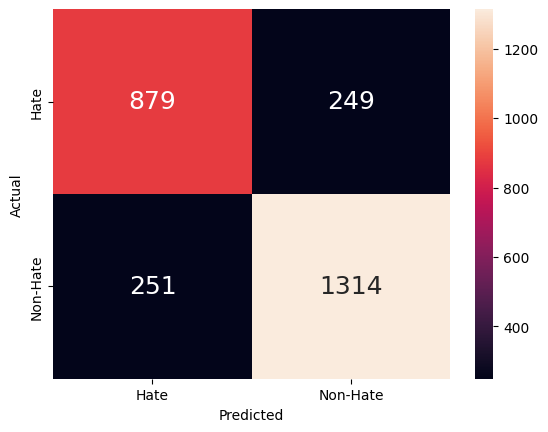

In [24]:
plot_heatmap(y_test, y_test_pred)

### BERT

- https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
- https://www.youtube.com/watch?v=hOCDJyZ6quA
- tensorflow hub bert https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
- bert will convert sentence into embeding vector which will feed to neural network for training 
- consist of preprocess and embeding 
- (4)BERT-RNN: The corresponding representational word vectors were trained by BERT model for the input text, which were then classified by RNN neural network. (5)word2vec-RNN: This model is a traditional text classification model. 4.3.
- BERT is a neural-network-based technique for language processing pre-training
- it is not a classification algorithm 
- BERT generates <b>contextual embeddings</b>, the input to the model is a sentence rather than a single word.
- BERT learns contextualized word representations, often referred to as contextual word embeddings or contextualized embeddings. Unlike traditional word embeddings, which assign a fixed vector representation to each word, BERT's word representations are sensitive to the context in which the word appears.

## Result Display

### Visualise

In [33]:
def plot_history(model_history, model_name):
    # Model performance charts
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)

    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])

    plt.title(f'{model_name} model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])

    plt.title(f'{model_name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.ylim(0, None)
    
    
    # plt.figure(figsize=(4,4))
    # plt.plot(model_history.history['loss'])
    # plt.plot(model_history.history['val_loss'])
    
    # plt.title(f'{model_name} model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='lower right')

### Results - confusion

In [30]:
def plot_heatmap(y_test, y_test_pred):
    # Heatmap
    ax = plt.subplot()

    # Plot the two-way Confusion Matrix
    sb.heatmap(confusion_matrix(y_test, y_test_pred, labels=["Hate","Non-Hate"]), 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(["Hate","Non-Hate"])
    ax.yaxis.set_ticklabels(["Hate","Non-Hate"])

    # Count
    df1 = pd.DataFrame({'Actual':y_test, 'Predict':y_test_pred})
    # print(df1.describe())
    print(f"Count: {df1['Actual'].value_counts()}")
    print()
    print(f"Count: {df1['Predict'].value_counts()}")
    print()

# test

In [64]:
df, dataset_name = load_dataset(3,2) 
x_train, y_train, y_train_binary, x_test, y_test, y_test_binary = split_data(df)
df_result = get_result_table()
print(dataset_name)
x_train[0]

class
Non-Hate    0.578737
Hate        0.421263
Name: proportion, dtype: float64
Train Set : (10384,) (10384,)
Test Set  : (2596,) (2596,)
Total  12980
SE2019


'best gift ever '

gab 
'white people post ww stupid allowing bullshit happen right noses western civilization smart cunning superior rest envy'

implicit
'dividing country small groups hate kkk neonazis etc droves crazies flocking well done dnc'

se 
'yeah bad bitch looking hoe kind average'

balanced
'reason poem woman '

### test single

In [25]:
pre_trained_model,em_model_name = get_word2vec_model()
custom_encoder, custom_embedding, embedding_name = pre_trained_em(x_train, pre_trained_model, em_model_name)
print(embedding_name)
print(dataset_name)

total vocab 34671
Converted 22504 words (12167 misses)
word2vec_trained
GabHateCorpus


In [22]:
# pre trained word embedding 
pre_trained_model,em_model_name = get_word2vec_model()
custom_encoder, custom_embedding, embedding_name = pre_trained_em(x_train, pre_trained_model, em_model_name)
print(embedding_name)
print(dataset_name)

total vocab 34666
Converted 22627 words (12039 misses)
word2vec_trained
GabHateCorpus


In [62]:
# learned word embedding
custom_encoder, custom_embedding, embedding_name = glove_em(x_train)
print(embedding_name)
print(dataset_name)

total vocab 34819


KeyboardInterrupt: 

In [ ]:
model, h = cnn(custom_encoder,custom_embedding, embedding_name,save=False, epoch=8, batch_size=256, lr=0.001)
model, h = rnn(custom_encoder,custom_embedding, embedding_name,save=False, epoch=8, batch_size=256, lr=0.001)
model, h = lstm(custom_encoder,custom_embedding, embedding_name,save=False, epoch=8, batch_size=256, lr=0.001)
model, h = gru(custom_encoder,custom_embedding, embedding_name,save=False, epoch=8, batch_size=256, lr=0.001)


In [26]:
model, h = gru(custom_encoder,custom_embedding, embedding_name,save=False, epoch=8, batch_size=256, lr=0.001)
y_test_pred = nn_predict(model)
get_result_single(y_test, y_test_pred, dataset_name+"_"+embedding_name+"cnn")

gru
Epoch 1/8
107/107 [==============================] - 11s 47ms/step - loss: 0.6128 - accuracy: 0.6726 - precision: 0.6724 - recall: 0.6734 - val_loss: 0.5889 - val_accuracy: 0.6898 - val_precision: 0.7260 - val_recall: 0.6006
Epoch 2/8
107/107 [==============================] - 3s 25ms/step - loss: 0.5746 - accuracy: 0.7017 - precision: 0.7014 - recall: 0.7050 - val_loss: 0.5724 - val_accuracy: 0.7070 - val_precision: 0.6928 - val_recall: 0.7341
Epoch 3/8
107/107 [==============================] - 2s 20ms/step - loss: 0.5614 - accuracy: 0.7118 - precision: 0.7067 - recall: 0.7265 - val_loss: 0.5664 - val_accuracy: 0.7077 - val_precision: 0.6850 - val_recall: 0.7593
Epoch 4/8
107/107 [==============================] - 2s 20ms/step - loss: 0.5491 - accuracy: 0.7169 - precision: 0.7087 - recall: 0.7387 - val_loss: 0.5596 - val_accuracy: 0.7130 - val_precision: 0.7108 - val_recall: 0.7095
Epoch 5/8
107/107 [==============================] - 2s 20ms/step - loss: 0.5381 - accuracy: 0.7284

,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,Balanced_word2vec_trained,0.722982,0.72398,0.723258,0.722819,0.729543,0.716094,3370.0,3431.0


### load test single

In [76]:
m = load_model_nn("Balanced_glove_lstm")
y_test_pred = nn_predict(m)
print(classification_report(y_test, y_test_pred, digits=3))
get_result_single(y_test, y_test_pred)
# plot_heatmap(y_test, y_test_pred)

models/Balanced_glove_lstm
Score:  0.44131216406822205
Accuracy:  0.810621440410614
              precision    recall  f1-score   support

        Hate      0.370     0.865     0.519       639
    Non-Hate      0.978     0.803     0.882      4784

    accuracy                          0.811      5423
   macro avg      0.674     0.834     0.700      5423
weighted avg      0.906     0.811     0.839      5423



,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,test,0.810621,0.674129,0.834359,0.700324,0.518519,0.88213,639.0,4784.0


### Multi test

In [31]:
def model_start_train(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name):
    model, h = cnn(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name,save=False, epoch=8, batch_size=256, lr=0.001)
    y_test_pred = nn_predict(model, x_test, y_test_binary)
    get_result_single(y_test, y_test_pred, dataset_name+"_"+embedding_name+"_cnn", df_result)

    model, h = rnn(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name,save=False, epoch=8, batch_size=256, lr=0.001)
    y_test_pred = nn_predict(model, x_test, y_test_binary)
    get_result_single(y_test, y_test_pred, dataset_name+"_"+embedding_name+"_rnn", df_result)

    model, h = lstm(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name,save=False, epoch=8, batch_size=256, lr=0.001)
    y_test_pred = nn_predict(model, x_test, y_test_binary)
    get_result_single(y_test, y_test_pred, dataset_name+"_"+embedding_name+"_lstm", df_result)

    model, h = gru(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name,save=False, epoch=8, batch_size=256, lr=0.001)
    y_test_pred = nn_predict(model, x_test, y_test_binary)
    get_result_single(y_test, y_test_pred, dataset_name+"_"+embedding_name+"_gru", df_result)

In [32]:
# word2vec word embedding 
pre_trained_model, model_name = get_word2vec_model()
custom_encoder, custom_embedding, embedding_name, missWord = pre_trained_em(x_train, pre_trained_model, model_name)
print(embedding_name)
print(dataset_name)

#model_start_train(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name)

total vocab 33332
total vector 3000000
Converted 21403 words (11929 misses)
word2vec_trained
Balanced


NameError: name 'model_start_train' is not defined

In [48]:
# fasttext word embedding 
pre_trained_model, model_name = get_fasttext_model()
custom_encoder, custom_embedding, embedding_name, missWord = pre_trained_em(x_train, pre_trained_model, model_name)
print(embedding_name)
print(dataset_name)

#model_start_train(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name)

total vocab 33332
total vector 999994
Converted 22650 words (10682 misses)
fasttext_trained
Balanced


In [65]:
# glove word embedding
custom_encoder, custom_embedding, embedding_name, missWord = glove_em(x_train)
print(embedding_name)
print(dataset_name)

#model_start_train(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name)

total vocab 19393
Total words  1917494
Converted 15043 words (4350 misses)
glove
SE2019


In [39]:
# learned word embedding
custom_encoder, custom_embedding, embedding_name = noTrained_em(x_train)
print(embedding_name)
print(dataset_name)

#model_start_train(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name)

total vocab 33332
no_train
Balanced


In [62]:
model, h = cnn(x_train, y_train_binary, x_test,y_test_binary,custom_encoder, custom_embedding, embedding_name, dataset_name,save=False, epoch=8, batch_size=256, lr=0.001)
y_test_pred = nn_predict(model, x_test, y_test_binary)
get_result_single(y_test, y_test_pred, dataset_name+"_"+embedding_name+"_cnn", df_result)

cnn
Epoch 1/8
107/107 [==============================] - 2s 14ms/step - loss: 0.6676 - accuracy: 0.6228 - precision: 0.6119 - recall: 0.6736 - val_loss: 0.6365 - val_accuracy: 0.6586 - val_precision: 0.6692 - val_recall: 0.6217
Epoch 2/8
107/107 [==============================] - 1s 10ms/step - loss: 0.6160 - accuracy: 0.6762 - precision: 0.6812 - recall: 0.6651 - val_loss: 0.6041 - val_accuracy: 0.6898 - val_precision: 0.6727 - val_recall: 0.7343
Epoch 3/8
107/107 [==============================] - 1s 10ms/step - loss: 0.5881 - accuracy: 0.6958 - precision: 0.6999 - recall: 0.6877 - val_loss: 0.5888 - val_accuracy: 0.6911 - val_precision: 0.7271 - val_recall: 0.6079
Epoch 4/8
107/107 [==============================] - 1s 10ms/step - loss: 0.5691 - accuracy: 0.7114 - precision: 0.7204 - recall: 0.6928 - val_loss: 0.5773 - val_accuracy: 0.7045 - val_precision: 0.7114 - val_recall: 0.6841
Epoch 5/8
107/107 [==============================] - 1s 10ms/step - loss: 0.5545 - accuracy: 0.7214 

In [63]:
df_result

,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,Balanced_glove_cnn,0.723032,0.724296,0.723176,0.722722,0.731985,0.713459,3384.0,3411.0
1,Balanced_glove_cnn,0.720677,0.721007,0.720594,0.720520,0.713898,0.727142,3384.0,3411.0
2,Balanced_word2vec_trained_cnn,0.729065,0.729507,0.728973,0.728879,0.721777,0.735982,3384.0,3411.0
3,Balanced_no_train_cnn,0.673878,0.673894,0.673847,0.673842,0.670434,0.677250,3384.0,3411.0
4,Balanced_no_train_cnn,0.657837,0.657987,0.657889,0.657798,0.661424,0.654172,3384.0,3411.0
5,Balanced_no_train_cnn,0.645769,0.646015,0.645675,0.645526,0.636240,0.654811,3384.0,3411.0
6,Balanced_no_train_cnn,0.646358,0.647428,0.646516,0.645863,0.659101,0.632625,3384.0,3411.0
7,Balanced_fasttext_trained_cnn,0.713171,0.714054,0.713038,0.712789,0.702306,0.723271,3384.0,3411.0
8,Balanced_fasttext_trained_cnn,0.718617,0.718721,0.718655,0.718603,0.720550,0.716657,3384.0,3411.0
9,Balanced_fasttext_trained_cnn,0.700809,0.709040,0.700409,0.697563,0.666229,0.728897,3384.0,3411.0


In [38]:
print(classification_report(y_test, y_test_pred, labels=["Hate","Non-Hate"]))

              precision    recall  f1-score   support

        Hate       0.55      0.44      0.49       639
    Non-Hate       0.93      0.95      0.94      4784

    accuracy                           0.89      5423
   macro avg       0.74      0.70      0.71      5423
weighted avg       0.88      0.89      0.89      5423



Count: Actual
Non-Hate    4784
Hate         639
Name: count, dtype: int64

Count: Predict
Non-Hate    4909
Hate         514
Name: count, dtype: int64



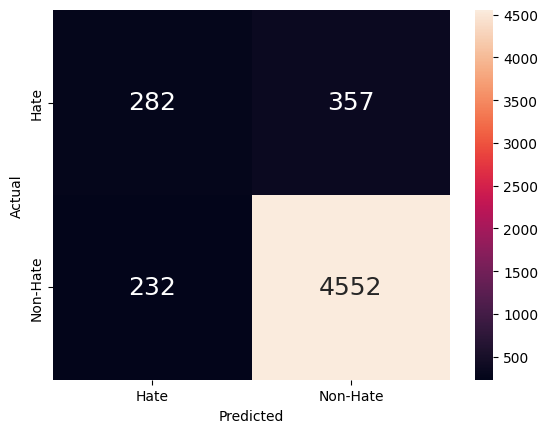

In [35]:
plot_heatmap(y_test,y_test_pred)

In [77]:
ds = dataset_name
em = embedding_name
get_result_multiple(x_test, y_test, [ds+"_"+em+"_cnn"])

models/Balanced_word2vec_trained_cnn


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,Balanced_word2vec_trained_cnn,0.708425,0.709118,0.708131,0.707979,0.696557,0.719400,3370.000000,3431.000000


In [60]:
ds ="GabHateCorpus"
em = 'fasttext_trained'
get_result_nn([ds+"_"+em+"_cnn",ds+"_"+em+"_rnn",ds+"_"+em+"_lstm",ds+"_"+em+"_gru"])

models/GabHateCorpus_fasttext_trained_cnn
models/GabHateCorpus_fasttext_trained_rnn
models/GabHateCorpus_fasttext_trained_lstm
models/GabHateCorpus_fasttext_trained_gru


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,GabHateCorpus_fasttext_trained_cnn,0.895814,0.753715,0.681969,0.709260,0.476367,0.942152,639.000000,4784.000000
1,GabHateCorpus_fasttext_trained_rnn,0.888069,0.763584,0.554869,0.570044,0.200264,0.939824,639.000000,4784.000000
2,GabHateCorpus_fasttext_trained_lstm,0.902821,0.822903,0.630348,0.673112,0.399088,0.947136,639.000000,4784.000000
3,GabHateCorpus_fasttext_trained_gru,0.900240,0.844451,0.601767,0.639506,0.332922,0.946089,639.000000,4784.000000


In [38]:
ds ="SE2019"
em = 'word2vec'
get_result_nn([ds+"_"+em+"_cnn",ds+"_"+em+"3_cnn",ds+"_no_train_cnn",ds+"_no_train3_cnn"])

models/SE2019_word2vec_cnn
models/SE2019_word2vec3_cnn
models/SE2019_no_train_cnn
models/SE2019_no_train3_cnn


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,SE2019_word2vec_cnn,0.731895,0.730780,0.719644,0.722074,0.669829,0.774319,568.000000,730.000000
1,SE2019_word2vec3_cnn,0.731895,0.730117,0.720425,0.722729,0.672316,0.773142,568.000000,730.000000
2,SE2019_no_train_cnn,0.710324,0.706902,0.699098,0.700933,0.647940,0.753927,568.000000,730.000000
3,SE2019_no_train3_cnn,0.705701,0.702347,0.704561,0.702902,0.674061,0.731742,568.000000,730.000000


In [43]:
h = cnn(custom_encoder,custom_embedding,embedding_name)
h = rnn(custom_encoder,custom_embedding,embedding_name)
h = lstm(custom_encoder,custom_embedding,embedding_name)
h = bilstm(custom_encoder,custom_embedding,embedding_name)
h = gru(custom_encoder,custom_embedding,embedding_name)

cnn
Epoch 1/10
763/763 [==============================] - 35s 44ms/step - loss: 0.3068 - accuracy: 0.8880 - precision: 0.6301 - recall: 0.2231 - val_loss: 0.2695 - val_accuracy: 0.8931 - val_precision: 0.6594 - val_recall: 0.2725
Epoch 2/10
763/763 [==============================] - 31s 41ms/step - loss: 0.1754 - accuracy: 0.9336 - precision: 0.8073 - recall: 0.6066 - val_loss: 0.3079 - val_accuracy: 0.8879 - val_precision: 0.5798 - val_recall: 0.3263
Epoch 3/10
763/763 [==============================] - 33s 43ms/step - loss: 0.0583 - accuracy: 0.9812 - precision: 0.9525 - recall: 0.8920 - val_loss: 0.4039 - val_accuracy: 0.8831 - val_precision: 0.5392 - val_recall: 0.3503
Epoch 4/10
763/763 [==============================] - 31s 41ms/step - loss: 0.0180 - accuracy: 0.9947 - precision: 0.9885 - recall: 0.9684 - val_loss: 0.4873 - val_accuracy: 0.8779 - val_precision: 0.5059 - val_recall: 0.3862
Epoch 5/10
763/763 [==============================] - 31s 41ms/step - loss: 0.0082 - accurac

INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_cnn\assets


INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_cnn\assets


acc 0.8930678367614746
rnn
Epoch 1/10
763/763 [==============================] - 115s 148ms/step - loss: 0.1489 - accuracy: 0.9422 - precision: 0.8159 - recall: 0.6863 - val_loss: 0.4125 - val_accuracy: 0.8698 - val_precision: 0.4570 - val_recall: 0.3024
Epoch 2/10
763/763 [==============================] - 121s 158ms/step - loss: 0.0597 - accuracy: 0.9793 - precision: 0.9230 - recall: 0.9083 - val_loss: 0.4803 - val_accuracy: 0.8551 - val_precision: 0.4013 - val_recall: 0.3593
Epoch 3/10
763/763 [==============================] - 119s 156ms/step - loss: 0.0302 - accuracy: 0.9889 - precision: 0.9576 - recall: 0.9525 - val_loss: 0.6529 - val_accuracy: 0.8654 - val_precision: 0.4317 - val_recall: 0.2934
Epoch 4/10
763/763 [==============================] - 117s 154ms/step - loss: 0.0173 - accuracy: 0.9945 - precision: 0.9813 - recall: 0.9744 - val_loss: 0.7736 - val_accuracy: 0.8595 - val_precision: 0.4041 - val_recall: 0.2964
Epoch 5/10
763/763 [==============================] - 115s 15

INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_rnn\assets


INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_rnn\assets


acc 0.869837760925293
lstm
Epoch 1/10
763/763 [==============================] - 358s 464ms/step - loss: 0.0824 - accuracy: 0.9579 - precision: 0.8641 - recall: 0.7814 - val_loss: 0.5779 - val_accuracy: 0.8426 - val_precision: 0.3786 - val_recall: 0.4341
Epoch 2/10
763/763 [==============================] - 296s 388ms/step - loss: 0.0180 - accuracy: 0.9944 - precision: 0.9809 - recall: 0.9734 - val_loss: 0.7569 - val_accuracy: 0.8510 - val_precision: 0.3776 - val_recall: 0.3234
Epoch 3/10
763/763 [==============================] - 301s 394ms/step - loss: 0.0100 - accuracy: 0.9971 - precision: 0.9897 - recall: 0.9867 - val_loss: 0.7764 - val_accuracy: 0.8459 - val_precision: 0.3679 - val_recall: 0.3503
Epoch 4/10
763/763 [==============================] - 307s 402ms/step - loss: 0.0070 - accuracy: 0.9979 - precision: 0.9927 - recall: 0.9900 - val_loss: 0.9544 - val_accuracy: 0.8462 - val_precision: 0.3754 - val_recall: 0.3743
Epoch 5/10
763/763 [==============================] - 311s 40

INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_lstm\assets


INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_lstm\assets


acc 0.8425516486167908
bilstm
Epoch 1/10
763/763 [==============================] - 306s 392ms/step - loss: 0.0464 - accuracy: 0.9696 - precision: 0.9083 - recall: 0.8382 - val_loss: 0.7997 - val_accuracy: 0.8448 - val_precision: 0.3724 - val_recall: 0.3802
Epoch 2/10
763/763 [==============================] - 310s 407ms/step - loss: 0.0054 - accuracy: 0.9984 - precision: 0.9957 - recall: 0.9910 - val_loss: 0.9759 - val_accuracy: 0.8414 - val_precision: 0.3605 - val_recall: 0.3713
Epoch 3/10
763/763 [==============================] - 314s 411ms/step - loss: 0.0057 - accuracy: 0.9983 - precision: 0.9937 - recall: 0.9924 - val_loss: 0.8995 - val_accuracy: 0.8392 - val_precision: 0.3500 - val_recall: 0.3563
Epoch 4/10
763/763 [==============================] - 309s 405ms/step - loss: 0.0032 - accuracy: 0.9988 - precision: 0.9963 - recall: 0.9940 - val_loss: 1.0786 - val_accuracy: 0.8367 - val_precision: 0.3507 - val_recall: 0.3832
Epoch 5/10
763/763 [==============================] - 316s

INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_bilstm\assets


INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_bilstm\assets


acc 0.844763994216919
gru
Epoch 1/10
763/763 [==============================] - 216s 278ms/step - loss: 0.0371 - accuracy: 0.9689 - precision: 0.8759 - recall: 0.8717 - val_loss: 0.8563 - val_accuracy: 0.8378 - val_precision: 0.3209 - val_recall: 0.2844
Epoch 2/10
763/763 [==============================] - 199s 261ms/step - loss: 0.0039 - accuracy: 0.9990 - precision: 0.9983 - recall: 0.9937 - val_loss: 1.0127 - val_accuracy: 0.8355 - val_precision: 0.3427 - val_recall: 0.3653
Epoch 3/10
763/763 [==============================] - 201s 264ms/step - loss: 0.0038 - accuracy: 0.9990 - precision: 0.9970 - recall: 0.9947 - val_loss: 0.9929 - val_accuracy: 0.8348 - val_precision: 0.3443 - val_recall: 0.3772
Epoch 4/10
763/763 [==============================] - 204s 268ms/step - loss: 0.0040 - accuracy: 0.9988 - precision: 0.9963 - recall: 0.9937 - val_loss: 1.0385 - val_accuracy: 0.8274 - val_precision: 0.3255 - val_recall: 0.3743
Epoch 5/10
763/763 [==============================] - 205s 269

INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_gru\assets


INFO:tensorflow:Assets written to: models/GabHateCorpus_no_train_gru\assets


acc 0.8377581238746643


In [51]:
ds ="Implicit_hate_corpus"
em = 'fasttext'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

models/Implicit_hate_corpus_fasttext_cnn
models/Implicit_hate_corpus_fasttext_rnn
models/Implicit_hate_corpus_fasttext_lstm
models/Implicit_hate_corpus_fasttext_bilstm
models/Implicit_hate_corpus_fasttext_gru


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,Implicit_hate_corpus_fasttext_cnn,0.691962,0.672204,0.673499,0.672811,0.593654,0.751968,2419,4025
1,Implicit_hate_corpus_fasttext_rnn,0.699876,0.682861,0.647670,0.652007,0.522940,0.781073,2419,4025
2,Implicit_hate_corpus_fasttext_lstm,0.714618,0.698594,0.669451,0.675276,0.562247,0.788304,2419,4025
3,Implicit_hate_corpus_fasttext_bilstm,0.717722,0.700199,0.677956,0.683571,0.579616,0.787525,2419,4025
4,Implicit_hate_corpus_fasttext_gru,0.714618,0.703246,0.662193,0.667807,0.543106,0.792508,2419,4025


In [44]:
ds ="GabHateCorpus"
em = 'no_train'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

models/GabHateCorpus_no_train_cnn
models/GabHateCorpus_no_train_rnn
models/GabHateCorpus_no_train_lstm
models/GabHateCorpus_no_train_bilstm
models/GabHateCorpus_no_train_gru


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,GabHateCorpus_no_train_cnn,0.879794,0.714788,0.645798,0.670194,0.407273,0.933114,334,2378
1,GabHateCorpus_no_train_rnn,0.832596,0.608088,0.604730,0.606354,0.307927,0.904782,334,2378
2,GabHateCorpus_no_train_lstm,0.842552,0.629033,0.621988,0.625322,0.340031,0.910613,334,2378
3,GabHateCorpus_no_train_bilstm,0.802729,0.608090,0.650749,0.621349,0.359281,0.883417,334,2378
4,GabHateCorpus_no_train_gru,0.835914,0.625620,0.631070,0.628232,0.350365,0.906098,334,2378


In [32]:
ds ="GabHateCorpus"
em = 'word2vec'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

models/GabHateCorpus_word2vec_cnn
models/GabHateCorpus_word2vec_rnn
models/GabHateCorpus_word2vec_lstm
models/GabHateCorpus_word2vec_bilstm
models/GabHateCorpus_word2vec_gru


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,GabHateCorpus_word2vec_cnn,0.887906,0.746150,0.642703,0.674457,0.410853,0.938060,334,2378
1,GabHateCorpus_word2vec_rnn,0.873894,0.694916,0.633426,0.655119,0.380435,0.929803,334,2378
2,GabHateCorpus_word2vec_lstm,0.888274,0.775411,0.591443,0.621357,0.303448,0.939266,334,2378
3,GabHateCorpus_word2vec_bilstm,0.884956,0.734727,0.633300,0.663554,0.390625,0.936482,334,2378
4,GabHateCorpus_word2vec_gru,0.893437,0.807469,0.605968,0.641856,0.341686,0.942026,334,2378


In [40]:
ds ="GabHateCorpus"
em = 'fasttext'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

,Model,Accuracy,precision,recall,f1-score,hate f1,hate support,non-hate f1,non-hate support
0,GabHateCorpus_fasttext_cnn,0.883944,0.724345,0.603634,0.632063,0.327635,983,0.936491,7151
1,GabHateCorpus_fasttext_rnn,0.879149,0.689995,0.503949,0.476797,0.017982,983,0.935613,7151
2,GabHateCorpus_fasttext_lstm,0.891320,0.795910,0.584577,0.613565,0.285945,983,0.941184,7151
3,GabHateCorpus_fasttext_bilstm,0.890214,0.755402,0.620362,0.653948,0.368011,983,0.939886,7151
4,GabHateCorpus_fasttext_gru,0.889107,0.740086,0.664044,0.691493,0.444581,983,0.938405,7151


In [38]:
ds = 'GabHateCorpus'
em = 'glove'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

,Model,Accuracy,Precision,Recall,F1-Score
0,GabHateCorpus_glove_cnn,0.887755,0.864472,0.887755,0.864063
1,GabHateCorpus_glove_rnn,0.885050,0.858332,0.885050,0.852100
2,GabHateCorpus_glove_lstm,0.892304,0.880023,0.892304,0.884057
3,GabHateCorpus_glove_bilstm,0.880747,0.872886,0.880747,0.876315
4,GabHateCorpus_glove_gru,0.882837,0.876953,0.882837,0.879606


In [7]:
ds = 'SE2019'
em = 'word2vec'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

models/SE2019_word2vec_cnn
models/SE2019_word2vec_rnn
models/SE2019_word2vec_lstm
models/SE2019_word2vec_bilstm
models/SE2019_word2vec_gru


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,SE2019_word2vec_cnn,0.700488,0.696548,0.700337,0.697045,0.664750,0.729341,1653,2240
1,SE2019_word2vec_rnn,0.669407,0.660556,0.655255,0.656664,0.590519,0.722809,1653,2240
2,SE2019_word2vec_lstm,0.713332,0.711090,0.693266,0.696179,0.623989,0.768369,1653,2240
3,SE2019_word2vec_bilstm,0.713075,0.708568,0.695976,0.698712,0.632928,0.764495,1653,2240
4,SE2019_word2vec_gru,0.717185,0.710524,0.706840,0.708230,0.657116,0.759344,1653,2240


In [36]:
ds = 'SE2019'
em = 'fasttext'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

models/SE2019_fasttext_cnn
models/SE2019_fasttext_rnn
models/SE2019_fasttext_lstm
models/SE2019_fasttext_bilstm
models/SE2019_fasttext_gru


,Model,Accuracy,precision,recall,f1-score,hate f1,non-hate f1,hate support,non-hate support
0,SE2019_fasttext_cnn,0.701259,0.696076,0.699025,0.696878,0.660438,0.733318,1653,2240
1,SE2019_fasttext_rnn,0.682764,0.679793,0.658064,0.659184,0.569536,0.748831,1653,2240
2,SE2019_fasttext_lstm,0.704598,0.697699,0.691701,0.693555,0.635384,0.751727,1653,2240
3,SE2019_fasttext_bilstm,0.711790,0.705390,0.706433,0.705855,0.664072,0.747638,1653,2240
4,SE2019_fasttext_gru,0.708965,0.702250,0.702471,0.702358,0.658014,0.746702,1653,2240


In [45]:
ds = 'SE2019'
em = 'glove'
get_result_nn([ds+"_"+em+"_cnn", ds+"_"+em+"_rnn", ds+"_"+em+"_lstm",ds+"_"+em+"_bilstm",ds+"_"+em+"_gru"])

,Model,Accuracy,Precision,Recall,F1-Score
0,SE2019_glove_cnn,0.709989,0.707252,0.709989,0.707052
1,SE2019_glove_rnn,0.661344,0.661685,0.661344,0.661509
2,SE2019_glove_lstm,0.732269,0.746559,0.732269,0.734036
3,SE2019_glove_bilstm,0.726328,0.730623,0.726328,0.727574
4,SE2019_glove_gru,0.756034,0.754855,0.756034,0.755169


In [149]:
get_result()

,Model,Accuracy,Precision,Recall,F1-Score
0,dtc,0.749350,0.747932,0.749350,0.748249
1,dtc-tfid,0.743780,0.743531,0.743780,0.743649
2,dtc-w2v,0.586706,0.589898,0.586706,0.588024
3,svm,0.768659,0.767394,0.768659,0.766195
4,svm-tfid,0.746008,0.760112,0.746008,0.731861
5,svm-w2v,0.590048,0.611645,0.590048,0.461541
6,lr,0.684738,0.690064,0.684738,0.686326
7,lr-tfid,0.694393,0.697312,0.694393,0.695449
8,lr-w2v,0.708504,0.705758,0.708504,0.705809
